# Importing libraries

In [93]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e3/sample_submission.csv
/kaggle/input/playground-series-s3e3/train.csv
/kaggle/input/playground-series-s3e3/test.csv


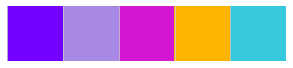

In [94]:
import warnings

import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
from tqdm import tqdm

init_notebook_mode(connected=True)
import seaborn as sns
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

pd.set_option("display.max_columns", 50)
warnings.filterwarnings("ignore")
# warnings.filterwarnings("ignore", category="FutureWarning")
# warnings.filterwarnings("ignore", category="DeprecationWarning")
# warnings.filterwarnings("ignore", category="UserWarning")

# Color Palette
custom_colors = ["#7400ff", "#a788e4", "#d216d2", "#ffb500", "#36c9dd"]
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)

## Loading the data

In [95]:
train = pd.read_csv("/kaggle/input/playground-series-s3e3/train.csv").drop("id", axis=1)
test = pd.read_csv("/kaggle/input/playground-series-s3e3/test.csv").drop("id", axis=1)
ss = pd.read_csv("/kaggle/input/playground-series-s3e3/sample_submission.csv")

In [96]:
train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,42,3,1,Laboratory Technician,4,Married,2596,5099,1,Y,Yes,13,3,2,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,46,3,1,Sales Representative,1,Married,2899,10778,1,Y,No,17,3,4,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,80,3,2,Sales Executive,4,Divorced,4627,16495,0,Y,No,17,3,4,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,40,3,2,Healthcare Representative,1,Married,5347,13384,3,Y,No,14,3,3,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,37,3,5,Manager,1,Single,19033,19805,1,Y,Yes,13,3,3,80,0,31,0,3,31,14,4,10,1


In [97]:
test.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,Male,43,3,1,Laboratory Technician,3,Single,2318,17778,1,Y,No,12,3,4,80,0,1,2,2,1,0,0,0
1,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,Male,67,3,2,Sales Executive,1,Divorced,5486,12421,6,Y,Yes,12,3,3,80,1,7,3,3,2,2,2,2
2,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,Male,41,3,1,Research Scientist,4,Divorced,2741,23577,4,Y,Yes,13,3,2,80,2,13,2,2,7,7,1,7
3,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,Male,89,2,2,Healthcare Representative,3,Single,5228,20364,1,Y,No,13,3,3,80,0,14,2,2,14,10,11,8
4,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,Male,79,3,1,Laboratory Technician,4,Single,1223,15178,1,Y,No,14,3,1,80,0,1,5,3,1,0,0,0


In [98]:
ss.head()

,id,Attrition
0,1677,0.119261
1,1678,0.119261
2,1679,0.119261
3,1680,0.119261
4,1681,0.119261


In [99]:
# Looking at the size of the data
train.shape, test.shape

((1677, 34), (1119, 33))

In [100]:
train.describe().T.style.bar(
    subset=["mean"], color=custom_colors[1]
).background_gradient(subset=["std"], cmap="Reds").background_gradient(
    subset=["50%"], cmap="coolwarm"
)

,count,mean,std,min,25%,50%,75%,max
Age,1677.000000,36.036971,8.507112,18.000000,30.000000,35.000000,41.000000,60.000000
DailyRate,1677.000000,892.749553,374.496259,107.000000,589.000000,890.000000,1223.000000,3921.000000
DistanceFromHome,1677.000000,8.683959,7.826143,1.000000,2.000000,7.000000,12.000000,29.000000
Education,1677.000000,2.937984,1.039078,1.000000,2.000000,3.000000,4.000000,15.000000
EmployeeCount,1677.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
EnvironmentSatisfaction,1677.000000,2.757901,1.086835,1.000000,2.000000,3.000000,4.000000,4.000000
HourlyRate,1677.000000,67.798450,19.435928,30.000000,51.000000,69.000000,84.000000,100.000000
JobInvolvement,1677.000000,2.782349,0.650664,1.000000,2.000000,3.000000,3.000000,4.000000
JobLevel,1677.000000,1.998807,1.083065,1.000000,1.000000,2.000000,2.000000,7.000000
JobSatisfaction,1677.000000,2.791890,1.097396,1.000000,2.000000,3.000000,4.000000,4.000000


### Distribution of the target variable

<AxesSubplot:xlabel='Attrition', ylabel='count'>

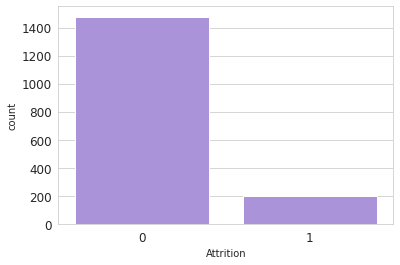

In [101]:
sns.countplot(train["Attrition"], color=custom_colors[1])

We can see that our data is unbalanced which mean it's a problem so we have to be care with this kind of problem.

Text(0.5, 0, '')

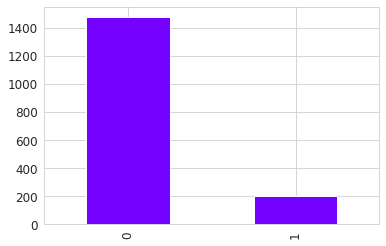

In [102]:
train["Attrition"].value_counts().plot(kind="bar",color=custom_colors[0])
plt.xlabel("")

### Age distribution

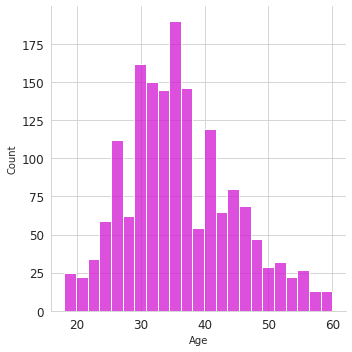

In [103]:
sns.displot(train['Age'],color=custom_colors[2])

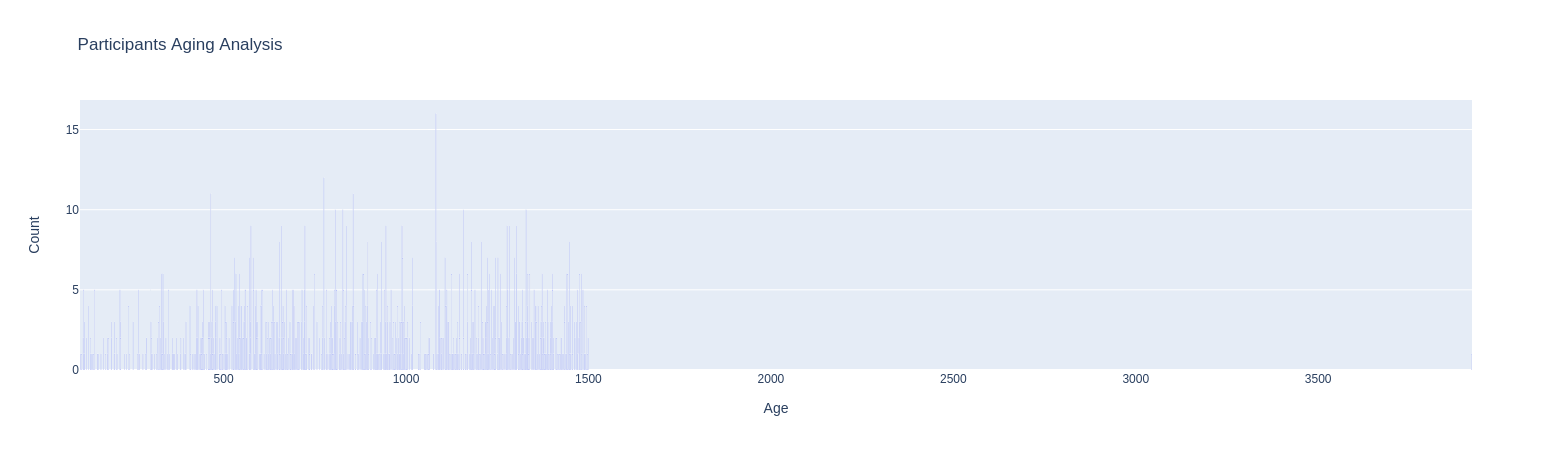

In [104]:
fig = px.bar(
    train.loc[1:, "DailyRate"].value_counts(),
    y="DailyRate",
    labels={"index": "Age", "DailyRate": "Count", "text": "Count"},
    text=(train.loc[1:, "DailyRate"].value_counts()),
    title="Participants Aging Analysis",
)
fig.show()

In [105]:
train.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,42,3,1,Laboratory Technician,4,Married,2596,5099,1,Y,Yes,13,3,2,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,46,3,1,Sales Representative,1,Married,2899,10778,1,Y,No,17,3,4,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,80,3,2,Sales Executive,4,Divorced,4627,16495,0,Y,No,17,3,4,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,40,3,2,Healthcare Representative,1,Married,5347,13384,3,Y,No,14,3,3,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,37,3,5,Manager,1,Single,19033,19805,1,Y,Yes,13,3,3,80,0,31,0,3,31,14,4,10,1


<Figure size 432x288 with 0 Axes>

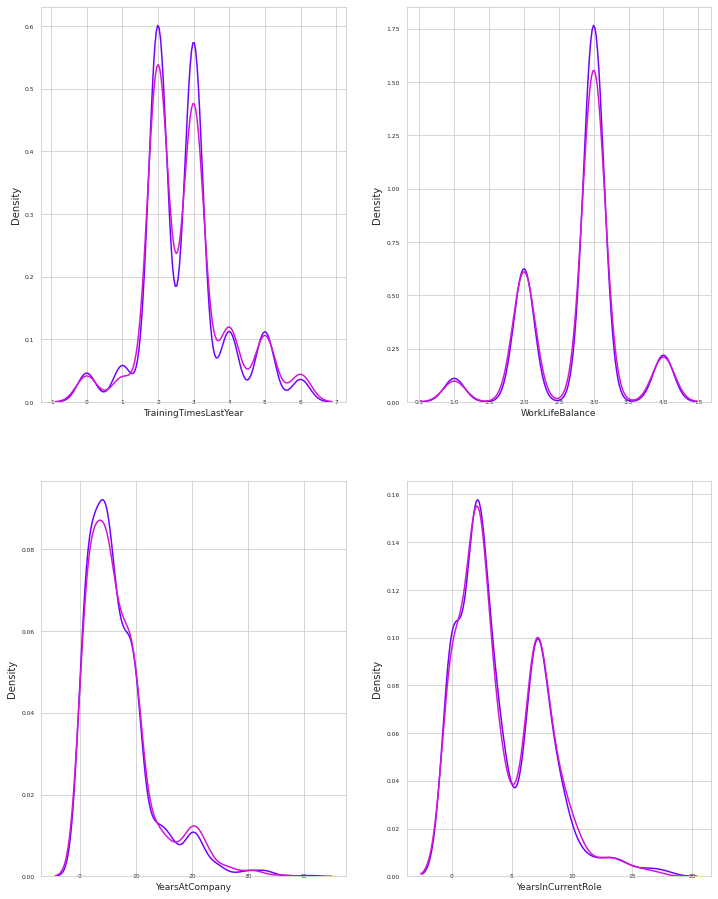

In [106]:
features = train.columns.values[27:31]
i = 0
sns.set_style("whitegrid")
plt.figure()
fig, ax = plt.subplots(10, 10, figsize=(12, 16))

for feature in features:
    i += 1
    plt.subplot(2, 2, i)
    sns.distplot(train[feature], hist=False, label="train", color=custom_colors[0])
    sns.distplot(test[feature], hist=False, label="test",color=custom_colors[2])
    plt.xlabel(feature, fontsize=9)
    locs, labels = plt.xticks()
    plt.tick_params(axis="x", which="major", labelsize=6, pad=-6)
    plt.tick_params(axis="y", which="major", labelsize=6)
plt.show();

In [107]:
# selecting categorical features
cat_features = [
    f for f in train.columns if f not in train.select_dtypes(include=["float", "int"])
]

In [108]:
cat_features

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [ ]:
# Use a for loop to create a countplot for each feature
for feature in cat_features:
    plt.figure()
    sns.countplot(x=feature, data=train, color = custom_colors[2],orient='v')
    plt.show()

 Now it's time to LabelEncode categorical features

In [ ]:
for col in cat_features:
    # initialize Label encoder for each features
    le = LabelEncoder()
    # fit transform label encoder on all data
    train[col] = le.fit_transform(train[col])
    test[col] = le.fit_transform(test[col])
train.head()

In [ ]:
test.head()

Now we have transform categorical variables to numerical using label encoder so the next thing we are going to do is to select our X and Y variable and then build a model.

In [ ]:
X = train.drop("Attrition", axis=1)
y = train.Attrition

In [ ]:
X.shape, test.shape

# Modeling

In [ ]:
params = {
    "objective": "Logloss",
    "colsample_bylevel": 0.08383650771477613,
    "depth": 11,
    "boosting_type": "Ordered",
    "bootstrap_type": "Bayesian",
    "bagging_temperature": 0.01880446878521802,
}

In [ ]:
%%time
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

preds = []
scores = []
feature_importance_df = pd.DataFrame()

for fold, (idx_train, idx_valid) in enumerate(kf.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = CatBoostClassifier(**params)

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        # early_stopping_rounds=400,
    )

    pred_valid = model.predict_proba(X_valid)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_valid, pred_valid)
    score = metrics.auc(fpr, tpr)
    scores.append(score)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X.columns
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold + 1
    feature_importance_df = pd.concat(
        [feature_importance_df, fold_importance_df], axis=0
    )

    print(f"Fold: {fold + 1} Score: {score}" "\n")
    print("||" * 40, "\n")

    test_preds = model.predict_proba(test)[:, 1]
    preds.append(test_preds)

print(f"Overall Validation Score: {np.mean(scores)}")

In [ ]:
cols = (
    feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:107]
    .index
)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14, 28))
sns.barplot(
    x="importance",
    y="Feature",
    data=best_features.sort_values(by="importance", ascending=False,),
)
plt.title("Features importance (averaged/folds)")
plt.tight_layout()
plt.savefig("FI.png")

In [ ]:
ss.head()

## Submission 

In [ ]:
predictions = np.mean(np.column_stack(preds), axis=1)

ss["Attrition"] = predictions
ss.to_csv("./basline_catboost.csv", index=False)
ss.head()